In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [27]:
from deepsvg.svglib.svg import SVG

from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif, make_grid, make_grid_lines, make_grid_grid
from deepsvg.svglib.geom import Bbox
from deepsvg.svgtensor_dataset import SVGTensorDataset, load_dataset
from deepsvg.utils.utils import batchify, linear

import torch

# Font generation and interpolation

In [5]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu") 

Load the pretrained model 

In [13]:
pretrained_path = "./pretrained/hierarchical_ordered_fonts.pth.tar"
from configs.deepsvg.hierarchical_ordered_fonts import Config

cfg = Config()
model = cfg.make_model().to(device)
utils.load_model(pretrained_path, model)
model.eval();

In [33]:
glyph2label = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [35]:
def sample_class(label, z=None, temperature=.3, filename=None, do_display=True, return_svg=False, return_png=False, *args, **kwargs):
    label_id = glyph2label.index(label)
    
    if z is None:
        z = torch.randn(1, 1, 1, cfg.model_cfg.dim_z).to(device) * temperature
    
    label, = batchify((torch.tensor(label_id),), device=device)
    commands_y, args_y = model.greedy_sample(None, None, None, None, label=label, z=z)
    tensor_pred = SVGTensor.from_cmd_args(commands_y[0].cpu(), args_y[0].cpu())

    svg_path_sample = SVG.from_tensor(tensor_pred.data, viewbox=Bbox(256), allow_empty=True).normalize().split_paths()
    
    if return_svg:
        return svg_path_sample
    
    return svg_path_sample.draw(file_path=filename, do_display=do_display, return_png=return_png, *args, **kwargs)

In [18]:
def get_z(temperature=.3):
    z = torch.randn(1, 1, 1, cfg.model_cfg.dim_z).to(device) * temperature
    return z

In [22]:
def sample_all_glyphs(z, filename=None):
    svg_digits = [sample_class(glyph, z=z, return_svg=True) for glyph in "0123456789"]
    svg_lower = [sample_class(glyph, z=z, return_svg=True) for glyph in "abcdefghijklmnopqrstuvwxyz"]
    svg_upper = [sample_class(glyph, z=z, return_svg=True) for glyph in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"]
    
    grid = make_grid_lines([svg_digits, svg_lower, svg_upper])
    grid.draw(file_path=filename)

## Random font generation

Sample a random latent vector and decode it conditionally on all glyph labels:

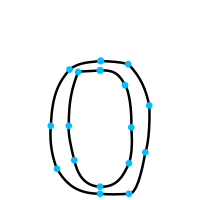

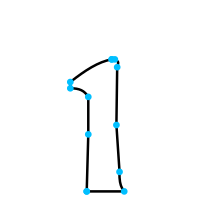

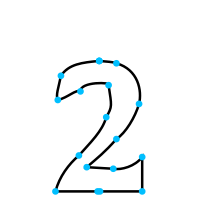

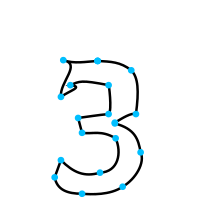

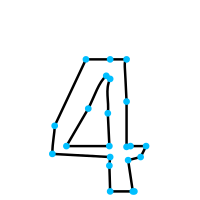

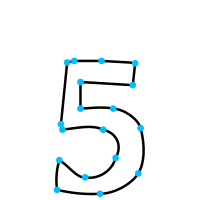

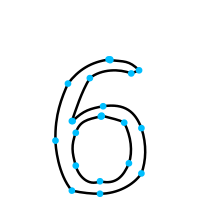

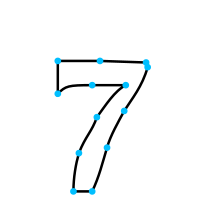

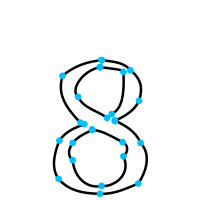

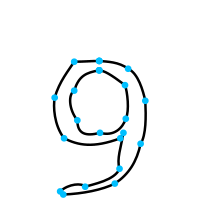

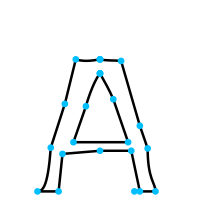

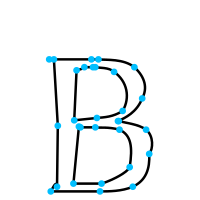

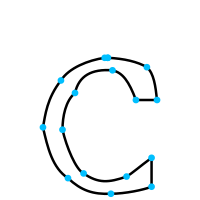

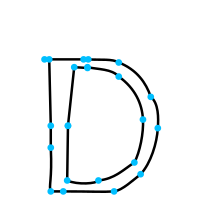

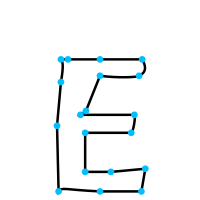

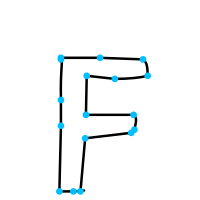

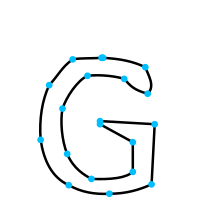

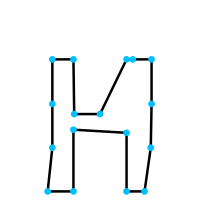

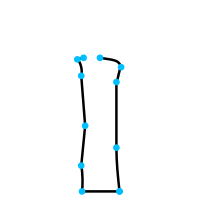

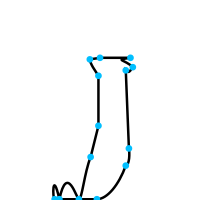

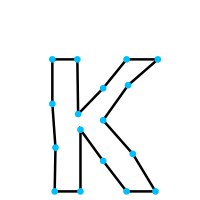

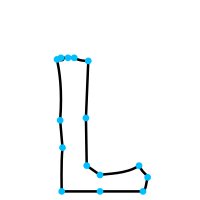

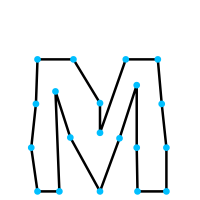

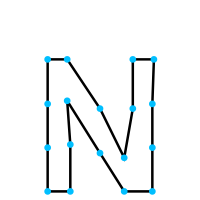

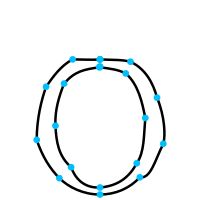

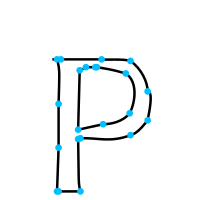

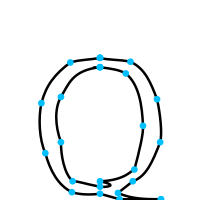

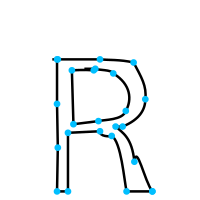

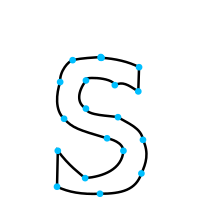

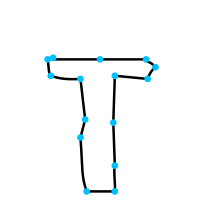

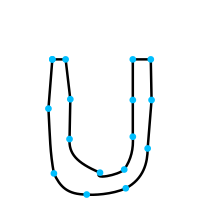

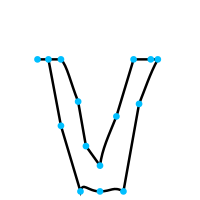

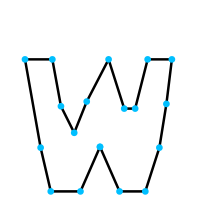

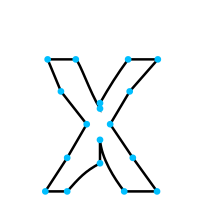

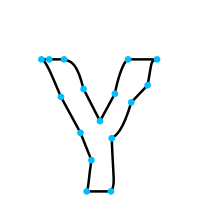

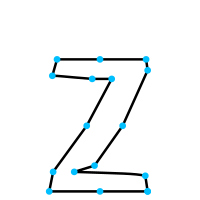

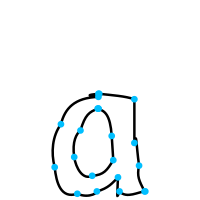

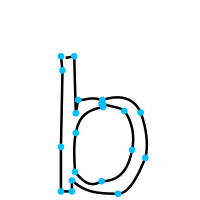

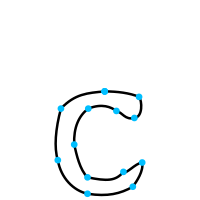

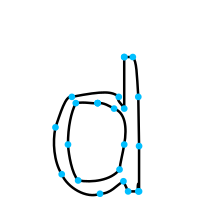

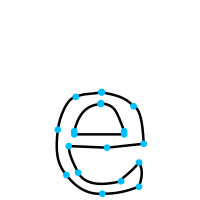

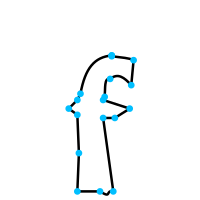

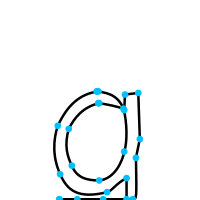

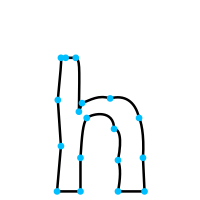

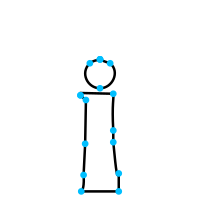

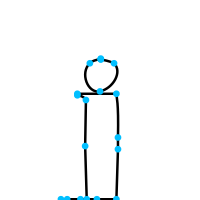

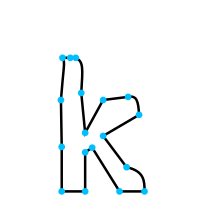

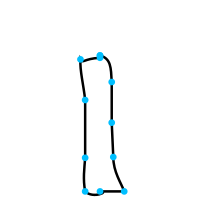

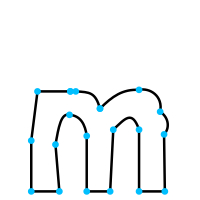

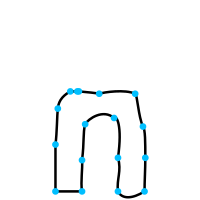

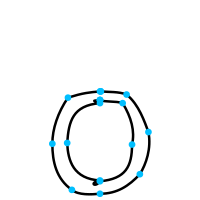

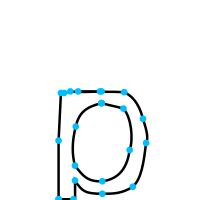

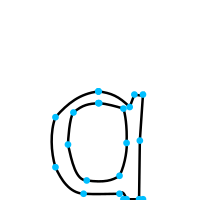

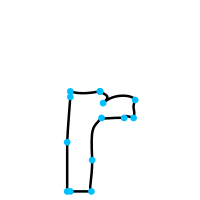

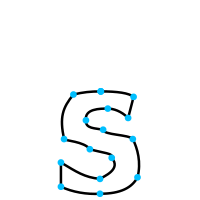

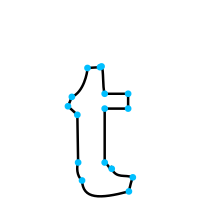

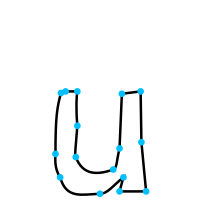

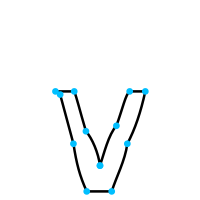

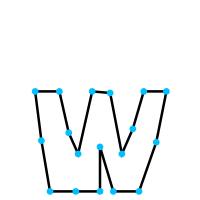

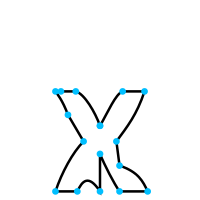

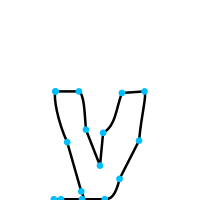

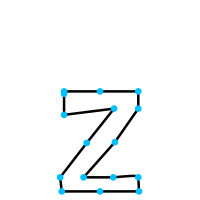

In [37]:
z = get_z()

for c in glyph2label:
    sample_class(c, z=z, with_points=True, with_moves=False)

Now let's make a convenient grid display of all glyphs!

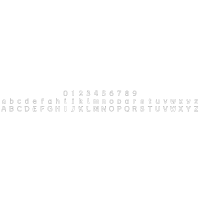

In [28]:
sample_all_glyphs(z)